# Part B: Analysing CSV Data

### Step 01: Import `pyspark` and initialize `Spark`.

In [43]:
import os
from pyspark.sql.functions import *
from datetime import datetime  # To convert the date column to datetime format
# pyspark functions to perform operations or functions specifically for pyspark dataframes
from pyspark.sql.functions import col, udf, countDistinct,month,year,dayofmonth
from pyspark.sql.types import DateType # To convert the Reported Date column to datetime
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
import pyspark.sql.functions as F   
import matplotlib.pyplot as plt # Visualization Library
import numpy as np
%matplotlib inline


In [2]:

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# create entry points to spark

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]")
spark = SparkSession(sparkContext=sc)\
        .builder\
        .appName("Assignment 1 Part B: Analysing CSV Data")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/Crime_Statistics_SA_2010_present.csv")\
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/Crime_Statistics_SA_2010_present.csv")\
        .getOrCreate()

### Step 02: Create Dataframe

In [3]:
# Read the csv into the spark dataframe, and inferschema is set to True as the dataset 
# needs to keep the original schema of the file. 

crime_df = spark.read.csv('Crime_Statistics_SA_2010_present.csv', header=True, inferSchema=True)
crime_df.show()

+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|Reported Date|Suburb - Incident|Postcode - Incident|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Offence Count|
+-------------+-----------------+-------------------+---------------------------+---------------------------+---------------------------+-------------+
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       PROPERTY DAMAGE A...|       Other property da...|            2|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|            1|
|    1/07/2010|         ADELAIDE|               5000|       OFFENCES AGAINST ...|       

In [4]:
# The number of records or rows in dataframe

print("The number of records in the csv file are:",crime_df.count())

The number of records in the csv file are: 727408


### Step 03:Write to Database

In [5]:
# The csv that was read is now written to a mongodb database and is in overwrite mode
# so whenever we write the csv to teh database it starts anew and no changes are made to
# teh dataframe.
crime_df.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

### Step 04: Read from Database

In [6]:
# The dataframe is now read from the mongodb database into the 
# pyspark dataframe in order to perform operations.

crime_df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()

In [7]:
crime_df.printSchema() 
# The schmema basically the datatypes, i.e. the dataframe structure
# is explained.

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



### Step 05: Calculate the statistics of numeric and string columns

In [8]:
crime_df.describe('Offence Count','Reported Date').show()

+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            727407|       727407|
|   mean|1.1715174585892079|         null|
| stddev|0.5787050930378097|         null|
|    min|                 1|    1/01/2011|
|    max|                28|    9/12/2018|
+-------+------------------+-------------+



` It shows the minimum is in 1/1/2011 and maximum in 9/12/2018 and that is wrong as even just by inspecting the dataframe we see 2019 is the highest year and 2010 the lowest year and this misjudgement is caused by .describe() comparing the ASCII VALUES as it is a string, and string comaprision is always donw by comparing ascii values so there are only 1's in the minimum and 9 and 8's in maximum it's the highest reported date.`

### Step 06: Change the data type of a column

**The `Reported Date` column is converted to datetime column using udf which is a method for implementing a user defined function in spark, so the return type is Datetype() and we sue strptime to convert it to actual datetime format that is yyyy-mm-dd.**

In [9]:
date_func =  udf (lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())

In [10]:
crimes_df = crime_df.withColumn('Reported Date', date_func(crime_df['Reported Date']))
#crimes_df.show()

In [11]:
crimes_df.printSchema() #The column has been sucessfully converted.

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



### Step 07: Preliminary data analysis

##### Question 1: How many level 2 offences are there ? Display the list of level 2 offences

In [12]:
# Null handling is done as there were null values in this column, so the nulls 
#are handled by using subset and df.dropna.
filtered_df = crimes_df.dropna(subset=["Offence Level 2 Description"])

In [13]:
# The number of offences for Level 2 are counted here.
level2_offences=filtered_df .select("Offence Level 2 Description").distinct().count()
print("THE NUMBER OF LEVEL 2 OFFENCES ARE:" ,level2_offences)

THE NUMBER OF LEVEL 2 OFFENCES ARE: 9


In [14]:
#How many level 2 offences are there? Display the list of level 2 offences.

list_level2_offences=filtered_df .select('Offence Level 2 Description').distinct().rdd.map(lambda r: r[0]).collect()
print("The different kinds of LEVEL 2 offences are:","\n",*list_level2_offences,sep="\n")

The different kinds of LEVEL 2 offences are:


ROBBERY AND RELATED OFFENCES
PROPERTY DAMAGE AND ENVIRONMENTAL
SEXUAL ASSAULT AND RELATED OFFENCES
HOMICIDE AND RELATED OFFENCES
ACTS INTENDED TO CAUSE INJURY
SERIOUS CRIMINAL TRESPASS
OTHER OFFENCES AGAINST THE PERSON
FRAUD DECEPTION AND RELATED OFFENCES
THEFT AND RELATED OFFENCES


##### Question 2: What is the number of offences against the person?

In [15]:
# Checked that offence against person is Level 1 crime.
filtered_df.select('Offence Level 1 Description').distinct().rdd.map(lambda r: r[0]).collect()

['OFFENCES AGAINST THE PERSON', 'OFFENCES AGAINST PROPERTY']

In [16]:
# Filtered out all the crimes against the person from that column.
df=filtered_df.filter(filtered_df['Offence Level 1 Description'] == 'OFFENCES AGAINST THE PERSON')

In [17]:
#The number of offences against the person committed are displayed here, by grouping Level
#1 crimes and then summing the against teh person count of offences and renaming the column.

offences_against_person=df.groupby('Offence Level 1 Description')\
.sum('Offence Count')\
.withColumnRenamed('sum(Offence Count)','Total Offences Against Person')
offences_against_person.show()


+---------------------------+-----------------------------+
|Offence Level 1 Description|Total Offences Against Person|
+---------------------------+-----------------------------+
|       OFFENCES AGAINST ...|                       175644|
+---------------------------+-----------------------------+



##### Question 3:How many serious criminal tresspasses with more than 1 offence count?

In [18]:
# Filtered out the serious criminal trespasses from Level 2.
serious_df=filtered_df.filter(filtered_df['Offence Level 2 Description'] =='SERIOUS CRIMINAL TRESPASS')

In [19]:
serious_df.show()

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            1|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|               5000|   2010-07-01|         ADELAIDE|[5d72651692e17160...|
|            1|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|            SCT - Residence|               5451|   2010-07-01|           AUBURN|[5d72651692e17160...|
|            1|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|            SCT - Residence|               5052|   2010-07-01|  

In [20]:
# Created a tempview and then counted the number of criminal trespassess 
# that are committed by people that exceed 1.


serious_df.createOrReplaceTempView("criminal_trespass")

criminal_df = spark.sql("SELECT COUNT (*) FROM (SELECT 'Offence Level 2 Description',`Offence Count` FROM criminal_trespass WHERE `Offence Count` > (1)) AS Criminal_Offence")
                             

In [21]:
criminal_df.show()   #There are 8579 criminal trespasses greater than 1.

+--------+
|count(1)|
+--------+
|    8579|
+--------+



##### Question 4: What percentage of crimes are offences against the property?

In [22]:
# Filtered out offences against the property from Level 1 Crimes

property_df=filtered_df.filter(filtered_df['Offence Level 1 Description'] =='OFFENCES AGAINST PROPERTY')

In [23]:
property_df.show()  #Filtered dataframe

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            2|       OFFENCES AGAINST ...|       FRAUD DECEPTION A...|       Obtain benefit by...|               5000|   2010-07-01|         ADELAIDE|[5d72651692e17160...|
|            1|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|            SCT - Residence|               5022|   2016-07-29|           GRANGE|[5d72651692e17160...|
|            1|       OFFENCES AGAINST ...|       THEFT AND RELATED...|            Theft from shop|               5169|   2012-05-15|  

In [24]:
#Calculated the total number or sum of property offences committed by people
# using agg(F.sum) tosum the Offence Count.

property_crimes=property_df.groupBy('Offence Level 1 Description').agg(F.sum('Offence Count'))\
.withColumnRenamed('sum(Offence Count)','Total property Crimes')
property_crimes.show()

+---------------------------+---------------------+
|Offence Level 1 Description|Total property Crimes|
+---------------------------+---------------------+
|       OFFENCES AGAINST ...|               676526|
+---------------------------+---------------------+



In [25]:
#Calculated the total sum of crimes committed throughout the dataframe.

filtered_df.createOrReplaceTempView("property")

total_df = spark.sql("SELECT SUM(`Offence Count`) AS Level1_Crimes FROM(SELECT 'Offence Level 1 Description',`Offence Count`FROM property)")
                             

In [26]:
total_df.show()

+-------------+
|Level1_Crimes|
+-------------+
|       852170|
+-------------+



In [27]:
676526/852170 * 100   # percenatge of crimes against property.

79.3886196416208

### Step 08: Exploratory data analysis

#####  Find the number of crimes per year. Plot the graph and explain your understanding of the graph.

In [28]:
## Total crimes per year are calculated here
Total_crimes_per_year=filtered_df.groupby(year(col("Reported Date")))\
.sum('Offence Count')\
.sort(year(col('Reported Date')))\
.withColumnRenamed("year(Reported date)","Year")\
.withColumnRenamed('sum(Offence Count)','Total Crimes per year')
Total_crimes_per_year.show()


+----+---------------------+
|Year|Total Crimes per year|
+----+---------------------+
|2010|                61402|
|2011|               122204|
|2012|               112962|
|2013|               106782|
|2014|               101750|
|2015|               105656|
|2016|               107593|
|2017|                50159|
|2018|                55758|
|2019|                27904|
+----+---------------------+



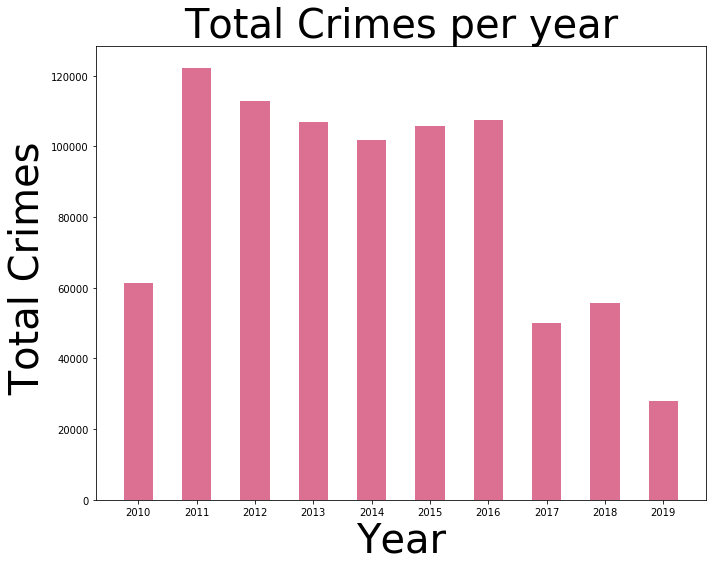

In [29]:
plt.figure(figsize=(10,8))
font = {'weight' : 'bold',
        'size'   : 15}
crimes=Total_crimes_per_year.collect()
y_axis = [row['Total Crimes per year'] for row in crimes]
bar_width = 0.5
objects=['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
x_pos=np.arange(len(objects))

plt.bar(x_pos,y_axis, bar_width, align='center', color='#DB7093')

plt.xticks(x_pos, objects)
plt.xlabel('Year',fontsize=40)
plt.ylabel(' Total Crimes',fontsize=40)
plt.title('Total Crimes per year',fontsize=40)
plt.tight_layout()
plt.rc('font', **font)
plt.show()

The number of crimes are the highest in 2011 that is 120000 and then 2012 and then some what consistent then in 2017 it starts decreasing but not linearly.The Years are plotted on x axis and the crimes committed in those years on y axis.  

##### Find the number of crimes per month.Plot the graph and explain your understanding of the graph.

In [30]:
## Total crimes per month are calculated here.
Total_crimes_per_month=filtered_df.groupby(month(col("Reported Date")))\
.sum('Offence Count')\
.sort(month(col('Reported Date')))\
.withColumnRenamed("month(Reported date)","Crime_Month")\
.withColumnRenamed('sum(Offence Count)','Total Crimes per month')
Total_crimes_per_month.show()


+-----------+----------------------+
|Crime_Month|Total Crimes per month|
+-----------+----------------------+
|          1|                 77516|
|          2|                 70429|
|          3|                 74931|
|          4|                 60037|
|          5|                 64246|
|          6|                 60687|
|          7|                 70954|
|          8|                 72839|
|          9|                 72595|
|         10|                 77153|
|         11|                 75191|
|         12|                 75592|
+-----------+----------------------+



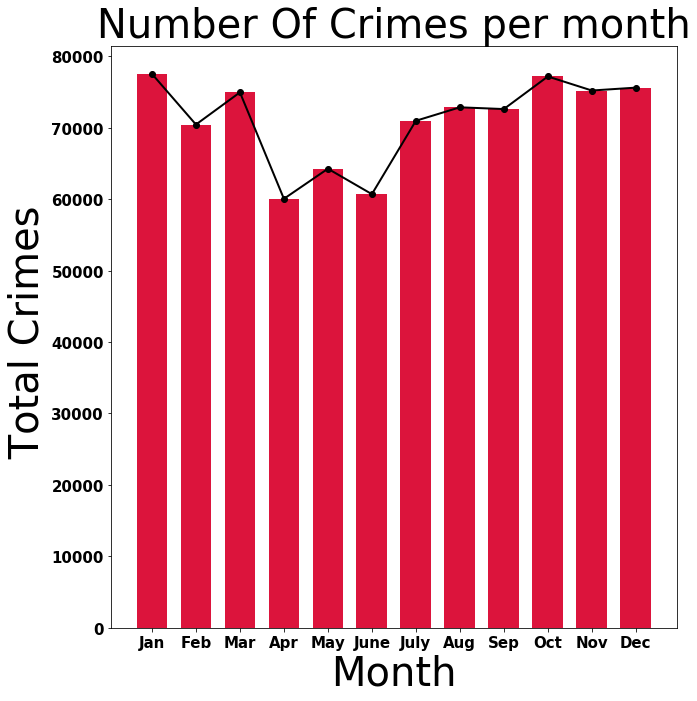

In [31]:
plt.figure(figsize=(10,10))
font = {'weight' : 'bold',
        'size'   : 15}
crimes_month=Total_crimes_per_month.collect()
bar_width = 0.7
Y_axis = [row['Total Crimes per month'] for row in crimes_month]
month=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']
x_axis=np.arange(len(month))
plt.bar(x_axis , Y_axis,bar_width, align='center', color='#DC143C')
plt.plot( x_axis , Y_axis, linestyle='-', marker='o', linewidth=2,color='black')
plt.xticks(x_axis, month)
plt.xlabel('Month',fontsize=40)
plt.ylabel(' Total Crimes',fontsize=40)
plt.title('Number Of Crimes per month',fontsize=40)
plt.tight_layout()
plt.rc('font', **font)
plt.show()

The highest occurence of crimes is in January but and lowest crimes in April but not much of an overall difference of crimes on an average throughout the months but the probability of crime in January is the highest.

##### Where do most crimes take place ? Find the top 20 suburbs (which would also display postcode for e.g. Caulfield - 3162) ? .Plot the graph and explain your understanding of the graph.

In [32]:
clean_df = filtered_df.dropna(subset=["Suburb - Incident"])

In [33]:
# The total number of crimes are grouped by their suburbs, so total crimes per suburb.

Total_crimes_per_suburb=clean_df.groupby(["Suburb - Incident","Postcode - Incident"])\
.sum('Offence Count')\
.withColumnRenamed('sum(Offence Count)','Total offences')\
.sort(col('Total offences').desc())\
.select(concat(col("Suburb - Incident"), lit("-"), col("Postcode - Incident")),'Total offences')\
.withColumnRenamed('concat(Suburb - Incident, -, Postcode - Incident)','Suburbs')

Total_crimes_per_suburb.show()




+--------------------+--------------+
|             Suburbs|Total offences|
+--------------------+--------------+
|       ADELAIDE-5000|         46701|
|   PORT AUGUSTA-5700|         13711|
|  MOUNT GAMBIER-5290|         13709|
|  MURRAY BRIDGE-5253|         12919|
|  MORPHETT VALE-5162|         12569|
|      SALISBURY-5108|         10806|
|   PORT LINCOLN-5606|         10779|
|      ELIZABETH-5112|         10731|
|NOT DISCLOSED-NOT...|          9375|
|   DAVOREN PARK-5113|          8082|
|PARAFIELD GARDENS...|          8040|
|  OAKLANDS PARK-5046|          7792|
|      PARALOWIE-5108|          7261|
|       PROSPECT-5082|          7234|
|     PORT PIRIE-5540|          7155|
|        MODBURY-5092|          7041|
|     SMITHFIELD-5114|          7000|
|SALISBURY NORTH-5108|          6538|
| WHYALLA STUART-5608|          6297|
|   MAWSON LAKES-5095|          6103|
+--------------------+--------------+
only showing top 20 rows



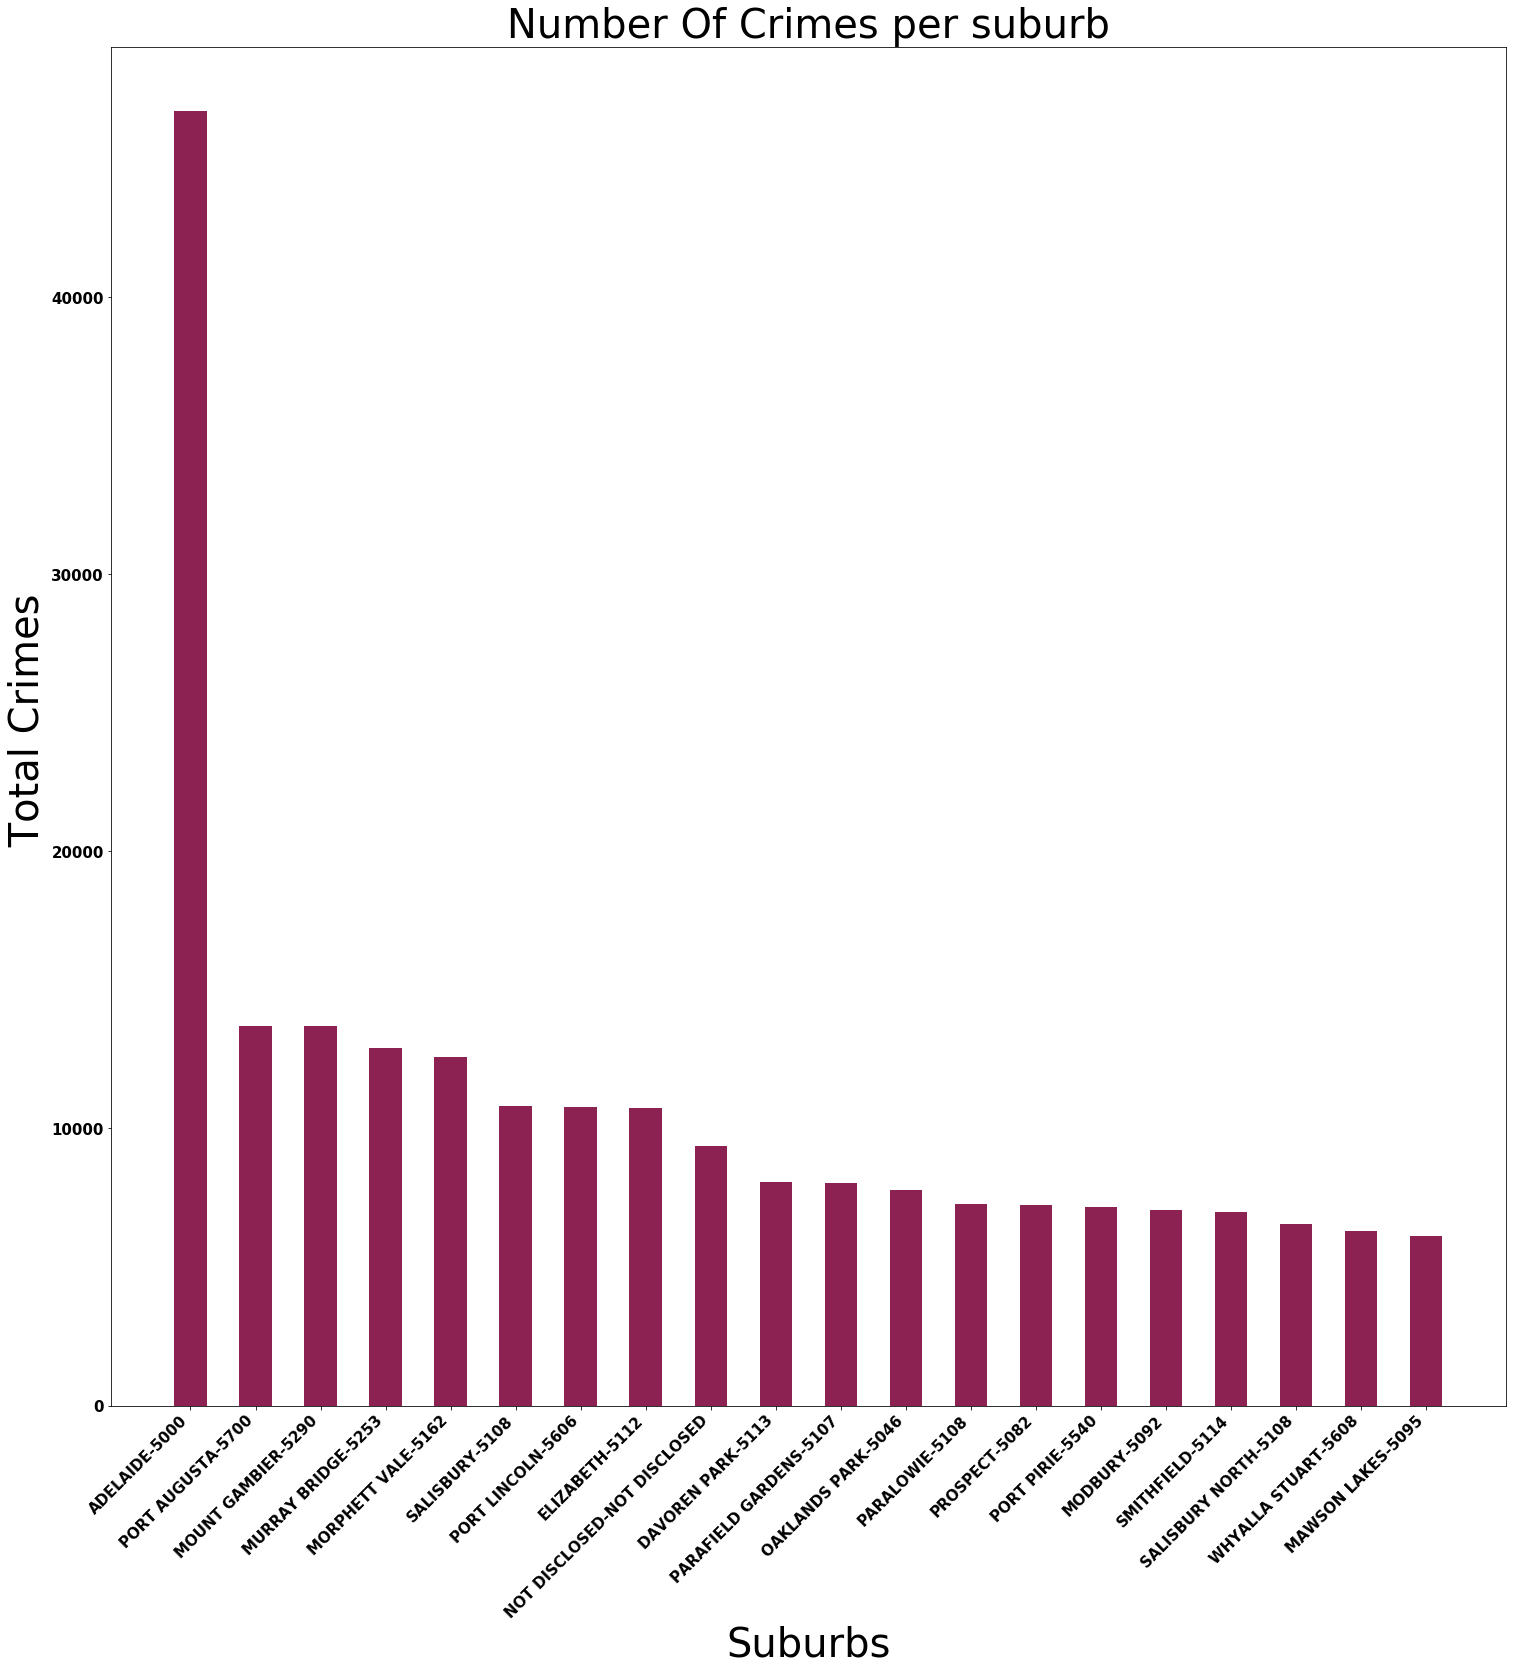

In [34]:
plt.figure(figsize=(25,25))
font = {'weight' : 'bold',
        'size'   : 20}
crimes_suburb=Total_crimes_per_suburb.take(20)
bar_width = 0.5
Y_coords = [row['Total offences'] for row in crimes_suburb]
x_coords=[row['Suburbs'] for row in crimes_suburb]
#x_plot=np.arange(len(suburbs))
plt.bar(x_coords , Y_coords,bar_width, align='center', color='#8B2252')
plt.xticks(x_coords,ha='right',rotation='45')
plt.xlabel('Suburbs',fontsize=40)
plt.ylabel(' Total Crimes',fontsize=40)
plt.title('Number Of Crimes per suburb',fontsize=40)
plt.rc('font', **font)
plt.show()

Adelaide has the highest number of crimes and hawson lakes the lowest but relatively still high as these are the 20 suburbs with highest crime numbers so deemed dangerous the suburbs with their postcodes are on the x axis and the number of crimes on y-axis.

##### Find the number of serious criminal trespasses by day and month. Plot a graph and explain your understanding of the graph.

In [36]:
df_offences=filtered_df.filter(filtered_df['Offence Level 2 Description'] == 'SERIOUS CRIMINAL TRESPASS')
df_offences.show()

+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description|Offence Level 3 Description|Postcode - Incident|Reported Date|Suburb - Incident|                 _id|
+-------------+---------------------------+---------------------------+---------------------------+-------------------+-------------+-----------------+--------------------+
|            1|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|        SCT - Non Residence|               5000|   2010-07-01|         ADELAIDE|[5d72651692e17160...|
|            1|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|            SCT - Residence|               5451|   2010-07-01|           AUBURN|[5d72651692e17160...|
|            1|       OFFENCES AGAINST ...|       SERIOUS CRIMINAL ...|            SCT - Residence|               5052|   2010-07-01|  

In [41]:
from pyspark.sql.functions import col,dayofweek
from pyspark.sql.functions import col

In [44]:
offences_day_month=df_offences.groupby([dayofweek(col('Reported Date')),month(col("Reported Date"))])\
.sum('Offence Count')\
.withColumnRenamed("month(Reported Date)","Month")\
.withColumnRenamed("sum(Offence Count)","Total_crimes")\
.withColumnRenamed('dayofweek(Reported Date)','Weekdays')\
.orderBy("Weekdays",'Month')
offences_day_month.show()

+--------+-----+------------+
|Weekdays|Month|Total_crimes|
+--------+-----+------------+
|       1|    1|        1309|
|       1|    2|        1143|
|       1|    3|        1310|
|       1|    4|        1097|
|       1|    5|        1138|
|       1|    6|        1071|
|       1|    7|        1334|
|       1|    8|        1223|
|       1|    9|        1295|
|       1|   10|        1384|
|       1|   11|        1330|
|       1|   12|        1280|
|       2|    1|        1722|
|       2|    2|        1661|
|       2|    3|        1609|
|       2|    4|        1366|
|       2|    5|        1598|
|       2|    6|        1416|
|       2|    7|        1663|
|       2|    8|        1821|
+--------+-----+------------+
only showing top 20 rows



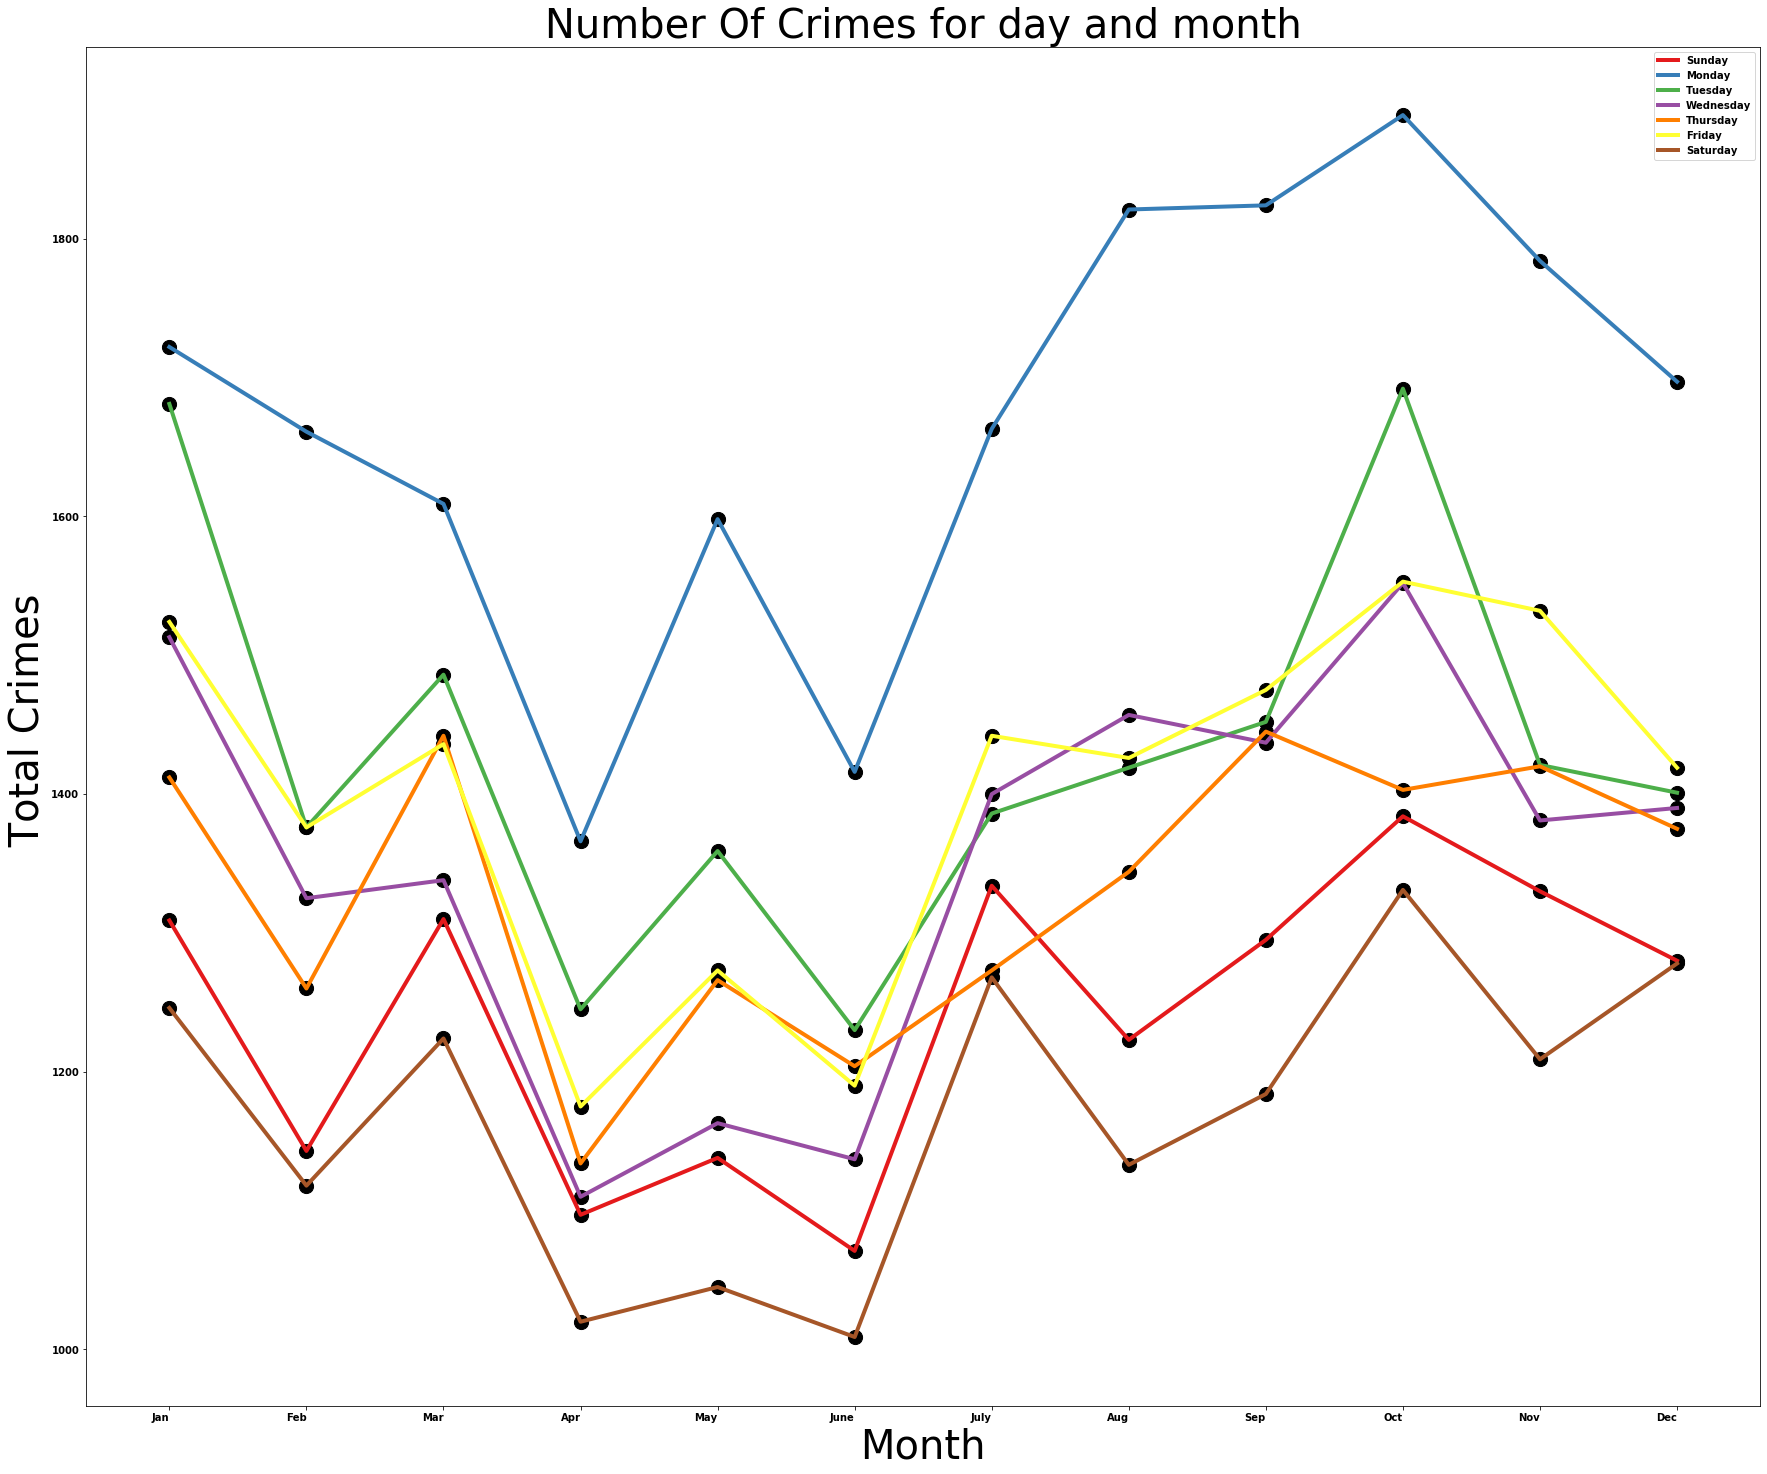

In [45]:
plt.figure(figsize=(30,25))

font = {'weight' : 'bold',
        'size'   : 30}
palette = plt.get_cmap('Set1')

weekdays=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
months=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']
x_ticks=np.arange(1,len(months)+1)
for column in range(0,7):
    weeks_df=offences_day_month.filter(offences_day_month['Weekdays']==column+1).collect()
    x_coords=[row['Month'] for row in weeks_df]
    y_coords=[row['Total_crimes'] for row in weeks_df]
    plt.plot(x_coords,y_coords,color=palette(column),linewidth=4,label=weekdays[column])
    plt.scatter(x_coords , y_coords, linestyle='-', color='black',marker='o',s=200)
plt.xticks(x_ticks,months,ha='right')
plt.xlabel('Month',fontsize=40)
plt.ylabel(' Total Crimes',fontsize=40)
plt.title('Number Of Crimes for day and month',fontsize=40)
plt.legend(loc='best', ncol=1)
plt.rc('font', **font)
plt.show()
plt.show()

`The number of crimes committed the most were on Mondays during the month of January and December. But the trend remains the same for all Weekdays for any weekday their highest crimes are in the months of January and December and lowest in the months of April and June so more crimes are committed during holiday time .The least number of crimes are committed on a Sunday assuming that no one gets out that much or just relax at home after a long week.
So highest crime Months Jan and Dec and highest crimes on a Monday then on Tuesday.`

In [ ]:
sc.stop()